Evaluating the anomaly detection method based on (averaged) localized p-value estimation (aK-LPE) proposed in [1] and [2].

1. K-LPE method:  
Zhao, Manqi, and Venkatesh Saligrama. "Anomaly detection with score functions based on nearest neighbor graphs."
Advances in neural information processing systems. 2009.

1. Averaged K-LPE method:  
Qian, Jing, and Venkatesh Saligrama. "New statistic in p-value estimation for anomaly detection."
IEEE Statistical Signal Processing Workshop (SSP). IEEE, 2012.

In [1]:
import numpy as np
from multiprocessing import cpu_count
from generate_data import MFA_model
from localized_pvalue_estimation import averaged_KLPE_anomaly_detection
from sklearn.metrics import (
    roc_curve,
    roc_auc_score, 
    average_precision_score, 
    precision_recall_curve
)
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Define some constants
n_jobs = max(cpu_count() - 2, 1)
seed_rng = np.random.randint(1, high=10000)
metric_primary = 'euclidean'
shared_nearest_neighbors = False
# Neighborhood size is chosen as a function of the number of data points. 
# In [1], it is recommended to chose `k = n^{2 / 5} = n^0.4`
neighborhood_constant = 0.4

In [3]:
# Generate data according to a mixture of factor analysis (MFA) model
np.random.seed(seed_rng)

# number of mixture components
n_components = 10
# dimension of the observed space
dim = 100

# dimension of the latent space. This determines the local intrinsic dimension
# dim_latent = 10
# model = MFA_model(n_components, dim, dim_latent=dim_latent, seed_rng=seed_rng)

# Can specify a range for the latent dimension instead of a single value
dim_latent_range = (10, 20)
model = MFA_model(n_components, dim, dim_latent_range=dim_latent_range, seed_rng=seed_rng)

# Generate nominal data from the MFA model
N = 1000
data, _ = model.generate_data(N)

# Generate a mixture of nominal and anomalous data as the test set
N_test_nom = 900
N_test_anom = 100
N_test = N_test_nom + N_test_anom
data_nom, _ = model.generate_data(N_test_nom)

# Anomalous points are generated either from a uniform distribution or a Gaussian distribution
x_min = np.min(data, axis=0)
x_max = np.max(data, axis=0)
x_mean = np.mean(data, axis=0)
x_std = np.std(data, axis=0)
data_anom = np.zeros((N_test_anom, dim))
for i in range(dim):
    # data_anom[:, i] = np.random.uniform(low=x_min[i], high=x_max[i], size=N_test_anom)
    data_anom[:, i] = np.random.normal(loc=x_mean[i], scale=x_std[i], size=N_test_anom)
    
data_test = np.concatenate([data_nom, data_anom], axis=0)
labels_test = np.concatenate([np.zeros(N_test_nom, dtype=np.int), 
                              np.ones(N_test_anom, dtype=np.int)])

In [4]:
# Initialize the anomaly detection (AD) model
detector = averaged_KLPE_anomaly_detection(
    neighborhood_constant=0.4, 
    n_neighbors=None, 
    metric=metric_primary, 
    metric_kwargs=None,
    shared_nearest_neighbors=shared_nearest_neighbors, 
    approx_nearest_neighbors=True,
    n_jobs=n_jobs, 
    seed_rng=seed_rng
)

In [5]:
# Fit the AD model to the nominal training data
detector.fit(data)

In [6]:
# Calculate the anomaly score of the test data
scores_test = detector.score(data_test)

In [7]:
# Calculate some performance metrics
au_roc = roc_auc_score(labels_test, scores_test)
au_roc_partial = roc_auc_score(labels_test, scores_test, max_fpr=0.01)
avg_prec = average_precision_score(labels_test, scores_test)
print("Area under the ROC curve = {:.6f}".format(au_roc))
print("Partial area under the ROC curve below FPR of 0.01 = {:.6f}".format(au_roc_partial))
print("Average precision = {:.6f}".format(avg_prec))

Area under the ROC curve = 0.992722
Partial area under the ROC curve below FPR of 0.01 = 0.702680
Average precision = 0.893104


In [8]:
# ROC curve and TPR at a few low FPR values
fpr_arr, tpr_arr, thresh = roc_curve(labels_test, scores_test, pos_label=1)
fpr_thresh = [0.001, 0.005, 0.01, 0.05]
print("TPR, FPR")
for a in fpr_thresh:
    mask = fpr_arr >= a
    tpr = tpr_arr[mask][0]
    fpr = fpr_arr[mask][0]
    print("{:.6f}, {:.6f}".format(tpr, fpr))

TPR, FPR
0.000000, 0.001111
0.490000, 0.006667
0.740000, 0.010000
1.000000, 0.050000


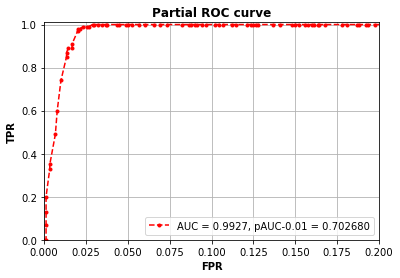

In [9]:
# ROC curve
fig = plt.figure()
ls = "AUC = {:.4f}, pAUC-0.01 = {:.6f}".format(au_roc, au_roc_partial)
plt.plot(fpr_arr, tpr_arr, linestyle='--', color='r', marker='.', label=ls)
plt.xlabel('FPR', fontweight='bold')
plt.ylabel('TPR', fontweight='bold')
plt.xlim([0.0, 0.2])
plt.ylim([0.0, 1.01])
plt.title('Partial ROC curve', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

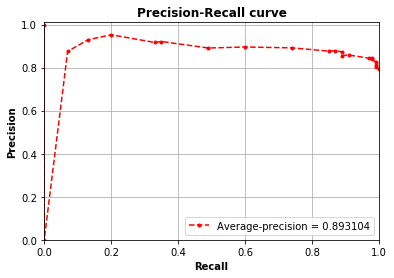

In [10]:
# Precision-Recall curve
precision_arr, recall_arr, _ = precision_recall_curve(labels_test, scores_test, pos_label=1)

fig = plt.figure()
ls = "Average-precision = {:.6f}".format(avg_prec)
plt.plot(recall_arr, precision_arr, linestyle='--', color='r', marker='.', label=ls)
plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Precision-Recall curve', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()